# Classificação desbalanceada

Esse notebook é uma tradução e adaptação do exemplo apresentado [no site do Keras](https://keras.io/examples/structured_data/imbalanced_classification/), criado por [fchollet](https://twitter.com/fchollet), e que utiliza essa base de dados do Kaggle [aqui](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).


## Introdução

Este exemplo mostra como treinar um modelo classificador quando os dados são altamente desbalanceados. O objetivo é treinar uma rede neural capaz de identificar operações financeiras fraudulentas.

## Vetorizando os dados CSV

In [1]:
import csv
import numpy as np

# Os dados reais contendo operações financeiras pode ser obtido em https://www.kaggle.com/mlg-ulb/creditcardfraud/
fname = "creditcard.csv"

todas_caracteristicas = []
todos_rotulos         = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0: # primeira linha da tabela: cabeçalho
            print("CABECALHO:", line.strip())
            continue  # pula cabeçalho da tabela
        fields = line.strip().split(",")
        todas_caracteristicas.append([float(v.replace('"', "")) for v in fields[:-1]])
        todos_rotulos.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("CARACTERISTICAS:", todas_caracteristicas[-1])

caracteristicas = np.array(todas_caracteristicas, dtype="float32")
valores_alvo    = np.array(todos_rotulos, dtype="uint8")
print("caracteristicas.shape:", caracteristicas.shape)
print("valores_alvo.shape:", valores_alvo.shape)

CABECALHO: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
CARACTERISTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
caracteristicas.shape: (284807, 30)
valores_alvo.shape: (284807, 1)


## Preparando os dados

In [2]:
num_amostras_validacao = int(len(caracteristicas) * 0.2) # deixaremos 20% dos dados para validação
X_trein = caracteristicas[:-num_amostras_validacao]
y_trein = valores_alvo[:-num_amostras_validacao]
X_val   = caracteristicas[-num_amostras_validacao:]
y_val   = valores_alvo[-num_amostras_validacao:]

print("Número de amostras de treinamento:", len(X_trein))
print("Número de amostras de validação:", len(X_val))

Número de amostras de treinamento: 227846
Número de amostras de validação: 56961


## Análise do desbalanceamento nos rótulos e atribuição de pesos diferentes

In [3]:
  qtdade_amostras_cada_classe = np.bincount(y_trein[:, 0]) # função do numpy que conta a quantidade de amostras para cada classe
  print(qtdade_amostras_cada_classe)
  print(
      "Número de amostras positivas no conjunto de dados: {} ({:.2f}% do total)".format(
          qtdade_amostras_cada_classe[1], 100 * float(qtdade_amostras_cada_classe[1]) / len(y_trein)
      )
  )

  peso_classe_0 = 1.0 / qtdade_amostras_cada_classe[0]
  peso_classe_1 = 1.0 / qtdade_amostras_cada_classe[1]

  print("Peso para classe 0:", peso_classe_0 )
  print("Peso para classe 1:", peso_classe_1 )

  pesos_classes = {0: peso_classe_0, 1: peso_classe_1} # cria um dicionário com o peso de cada classe

[227429    417]
Número de amostras positivas no conjunto de dados: 417 (0.18% do total)
Peso para classe 0: 4.396976638863118e-06
Peso para classe 1: 0.002398081534772182


## Normalizando os dados usando média e desvio padrão

In [4]:
media    = np.mean(X_trein, axis=0)
X_trein -= media
X_val   -= media
desvio   = np.std(X_trein, axis=0)
X_trein /= desvio
X_val   /= desvio

## Criando uma rede neural para classificação binária

In [5]:
import keras

modelo = keras.Sequential(
    [
        keras.Input(shape=X_trein.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,777 (546.00 KB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 0 (0.00 B)

## Treinando o modelo levando em conta o desbalaceamento entre as classes

In [6]:
modelo.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy")

modelo.fit(
    X_trein,
    y_trein,
    batch_size=2048, # define a quantidade de amostras de cada "mini-lote" (se comentarmos essa linha, será usado o padrão de 32 amostras por mini-lote)
    epochs=30,
    class_weight=pesos_classes,
)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.7881e-06
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.0145e-06
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0048e-06
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1376e-06
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3538e-07
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.4638e-07
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2655e-07
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1519e-07
Epoch 9/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6173e-07
Epoch 10/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0028e-07
Epoch 11/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7065e-07
Epoch 12/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9237e-07
Epoch 13/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5100e-07
Epoch 14/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4655e-07


In [7]:
probabilidades = modelo.predict(X_val) # cálculo da saída da rede neural para as transações de validação

print(probabilidades.shape) # verificando o shape das probabilidades

print(probabilidades[:10]) # verificando as probabilidades das primeiras 10 amostras de validação

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
(56961, 1)
[[4.8201376e-17]
 [4.7592812e-15]
 [9.4175321e-22]
 [1.0060110e-07]
 [2.7937576e-04]
 [3.6831516e-10]
 [1.1908388e-11]
 [4.4646505e-19]
 [1.2289605e-06]
 [1.1670948e-16]]


In [8]:
y_val_est = (probabilidades >= 0.5).astype(int)

print(y_val_est.shape)
print(y_val_est[:10]) # mostrado a classe prevista para as primeiras 1 amostras de validação

(56961, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Plotando matriz de confusão para os dados de validação

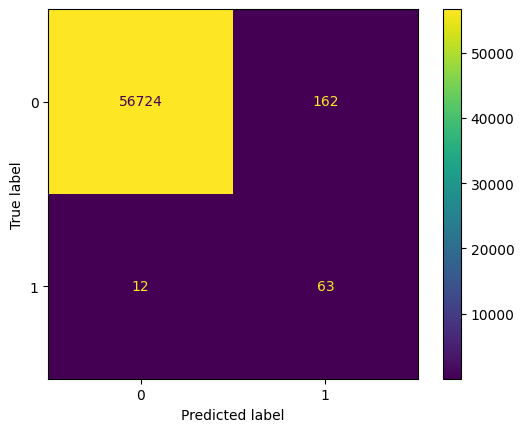

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


A partir da matriz de confusão, gerada para as transações de validação, podemos perceber que (os valores abaixo podem variar ligeiramente devido à inicialização aleatória dos pesos da rede neural):

- 56961 transações de validação foram avalidadas pela rede neural
- 66 transações foram corretamente identificadas como fraudulentas
- 8 transações fraudulentas não foram detectadas
- Infelizmente, 441 transações não fraudulentas foram incorretamente classificadas como fraudulentas.


In [10]:
# calculando precisão, recall e f1 score

rotulos = ["y=0","y=1"]

tp        = np.diag(cm) # Diagonal represents true positives
precisao  = dict()
revocacao = dict()
f1_score  = dict()
for i in range(len(rotulos)):
  col = cm[:, i]
  fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

  row = cm[i, :]
  fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

  valor_precisao  = tp[i] / (tp[i] + fp)
  valor_revocacao = tp[i] / (tp[i] + fn)
  valor_f1_score  = 2*valor_precisao*valor_revocacao / (valor_precisao + valor_revocacao)

  precisao[rotulos[i]] = valor_precisao
  revocacao[rotulos[i]]    = valor_revocacao
  f1_score[rotulos[i]]  = valor_f1_score

print("precisao: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

precisao:  {'y=0': 0.9997884940778342, 'y=1': 0.28}
recall:  {'y=0': 0.9971521991351123, 'y=1': 0.84}
F1 score:  {'y=0': 0.998468606431853, 'y=1': 0.42}


Note que existe um valor de precisão, revocação e f1 score para cada classe. Nos nossos slides, tais valores foram calculados tomando-se a classe $y=1$ como referência. Emtretanto, nada impede que essas 3 métricas sejam calculadas tomando-se a classe $y=0$ como referência. Imagine, por exemplo, se tivéssemos usado o rótulo $y=0$ para operações fraudulentas, e $y=1$ para operações não fraudulentas. Nesse caso, faria mais sentido observar tais métricas tomando-se o $y=0$ como referência.


Nos valores calculados observamos que, tomando os valores referentes à classe $y=1$ como referência (operações fraudulentas), o valor de precisão é relativamente baixo (mesma conclusão a qual já havíamos chegado nos nossos slides). Apesar disso, observando a matriz de confusão nós notamos que trata-se de um bom modelo para a aplicação em tela.

## Parabéns

Parabéns, você criou uma rede neural capaz de identificar operações financeiras fraudulentas.

# Parte 2  
1) O modelo classificou corretamente 63 casos positivos, em 12 casos, o modelo previu que eram positivos, mas na verdade eram negativos, além disso, o modelo deixou de identificar 162 casos positivos, classificando-os incorretamente como negativos, por fim, o modelo identificou corretamente 56724 casos negativos.

Para a classe y=1 (positivo):  
Apenas 28% das predições positivas estão corretas, isso significa que o modelo gera muitos falsos positivos, prevendo erroneamente amostras negativas como positivas. O modelo classificou poucos falsos negativos, capturando 84% dos casos reais da classe positiva.  

2)  Levando as previsões erradas em dados novos, se o foco for reduzir falsos positivos, adicionar regularização ao modelo pode reduzir a complexidade, além de ajustar os pesos para penalizar mais os erros dessa classe.
